# Set up imports

In [7]:
import os
if not os.path.exists("./notebooks"):
    %cd ..

import numpy as np
from src.data_processing import load_mean_std

import torch
from torchvision import transforms
import src.model
from src.training import monte_carlo_predictions


# 0. Set Device 

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Define Monte Carlo Dropout testing

In [9]:
def monte_carlo_dropout(model, test_loader, samples = 20):
    predictions = []
    for _ in range(samples):
        predictions.append(monte_carlo_predictions(model, test_loader))
        
    predictions = np.stack(predictions , 0)
    mean_predictions = np.mean(predictions, axis=0)
    entropy = -1.0  * np.sum(mean_predictions * np.log(mean_predictions + 1e-16), axis=-1)
    return mean_predictions, entropy

# 2. Calculate Monte Carlo Dropout Predictions for Model


In [10]:
from src.dataset import prepare_dataset_loaders
from src.config import DATASET_DIR 
mean, std = load_mean_std(f"{DATASET_DIR}/scaling_params.json")
name = "DropoutCNN"
model = src.model.DropoutCNN()  

batch_size = 10 # TODO make it not value from keyboard.
# Load the saved state dictionary
model_path = f"./models/{name}.pth"
model.load_state_dict(torch.load(model_path, weights_only=True))
model.device = device


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
train_loader, val_loader, test_loader = prepare_dataset_loaders(transform, batch_size)
probs, entropy = monte_carlo_dropout(model, val_loader, samples=20)

print("Entropy:", entropy)


# Plot Monte Carlo Dropout

Text(0, 0.5, 'Frequency')

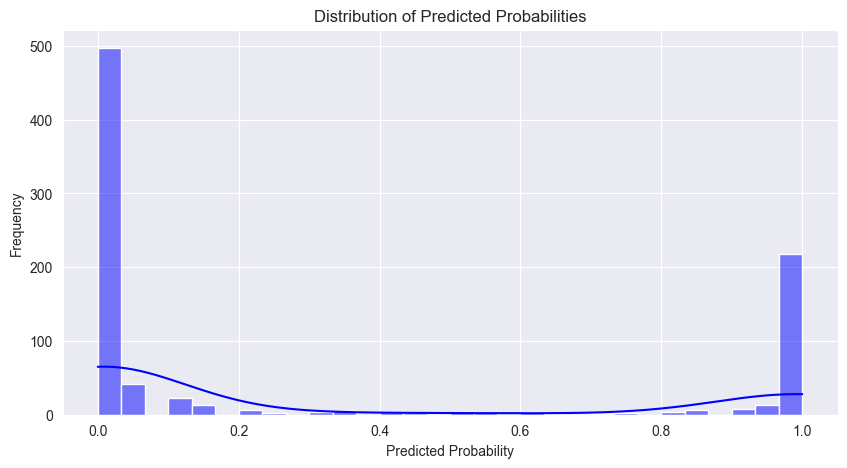

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predicted Probabilities
plt.figure(figsize=(10, 5))
sns.histplot(probs, bins=30, kde=True, color='blue')
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
